In [1]:
# install fast.ai course content.
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
#@title Default title text
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
import fastai
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False, verbose=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [6]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet')

In [7]:
path.ls()

[WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/images')]

In [8]:
path_anno = path/'annotations'
path_img = path/'images'

In [9]:
(path_anno,path_img)

(WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/images'))

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [10]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/atma6951/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [11]:
len(fnames)

7390

In [12]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c: Union[pathlib.Path, str], check_ext: bool = True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



In [13]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [14]:
help(ImageDataBunch.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path: Union[pathlib.Path, str], fnames: Collection[pathlib.Path], pat: str, valid_pct: float = 0.2, **kwargs) method of builtins.type instance
    Create from list of `fnames` in `path` with re expression `pat`.



In [15]:
get_transforms?

In [16]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [17]:
%%time
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Wall time: 1.34 s


In [17]:
type(data)

fastai.vision.data.ImageDataBunch

In [18]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\atma6951\.fastai\data\oxford-iiit-pet\images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_pit_bull_terrier,staffordshire_bull_terrier,Abyssinian,Egyptian_Mau,Maine_Coon
Path: C:\Users\atma6951\.fastai\data\oxford-iiit-pet\images;

Test: None

In [19]:
data.valid_ds.x

ImageList (1478 items)
Image (3, 375, 500),Image (3, 375, 500),Image (3, 500, 375),Image (3, 224, 300),Image (3, 333, 500)
Path: C:\Users\atma6951\.fastai\data\oxford-iiit-pet\images

In [20]:
data.train_ds

LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\atma6951\.fastai\data\oxford-iiit-pet\images

In [20]:
help(data.show_batch)

Help on method show_batch in module fastai.basic_data:

show_batch(rows: int = 5, ds_type: fastai.basic_data.DatasetType = <DatasetType.Train: 1>, reverse: bool = False, **kwargs) -> None method of fastai.vision.data.ImageDataBunch instance
    Show a batch of data in `ds_type` on a few `rows`.



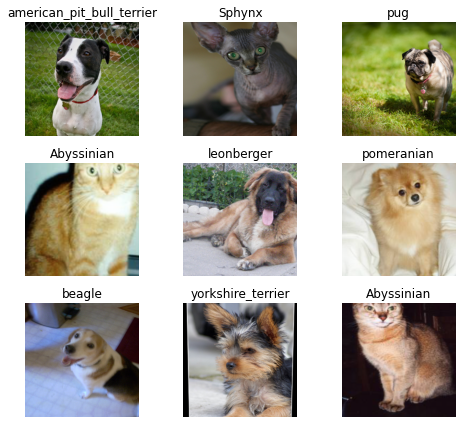

In [22]:
data.show_batch(rows=3, figsize=(7,6))

In [23]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

In [24]:
data.batch_size

64

In [37]:
data

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Egyptian_Mau,pug,basset_hound,Siamese,Birman
Path: /Users/atma6951/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
samoyed,pomeranian,Persian,Siamese,Egyptian_Mau
Path: /Users/atma6951/.fastai/data/oxford-iiit-pet/images;

Test: None

In [72]:
data.device = 'cpu'

In [73]:
data.device

'cpu'

In [42]:
data.dl()

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x1a220eed68>, device=device(type='cpu'), tfms=[functools.partial(<function _normalize_batch at 0x1a1ef90510>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x1a1e80eae8>)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [23]:
from pprint import pprint
pprint(dir(fastai.vision.models), compact=True)

['BasicBlock', 'Darknet', 'DynamicUnet', 'ResLayer', 'ResNet', 'SqueezeNet',
 'UnetBlock', 'WideResNet', 'XResNet', '__builtins__', '__cached__', '__doc__',
 '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__',
 'alexnet', 'darknet', 'densenet121', 'densenet161', 'densenet169',
 'densenet201', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50',
 'squeezenet1_0', 'squeezenet1_1', 'unet', 'vgg11_bn', 'vgg13_bn', 'vgg16_bn',
 'vgg19_bn', 'wrn', 'wrn_22', 'xception', 'xresnet', 'xresnet101', 'xresnet152',
 'xresnet18', 'xresnet34', 'xresnet50']


In [25]:
error_rate?

In [26]:
%%time
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/atma6951/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [01:28<00:00, 984263.02it/s] 


CPU times: user 3.02 s, sys: 1.67 s, total: 4.68 s
Wall time: 1min 29s


In [27]:
type(learn)

fastai.basic_train.Learner

In [28]:
pprint(dir(learn), compact=True)

['TTA', '__annotations__', '__class__', '__dataclass_fields__',
 '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__',
 '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__',
 '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__',
 '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__',
 '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__',
 '_test_writeable_path', 'add_time', 'apply_dropout', 'backward', 'bn_wd',
 'callback_fns', 'callbacks', 'clip_grad', 'create_opt', 'data', 'destroy',
 'dl', 'export', 'fit', 'fit_fc', 'fit_one_cycle', 'freeze', 'freeze_to',
 'get_preds', 'init', 'interpret', 'layer_groups', 'load', 'loss_func',
 'lr_find', 'lr_range', 'metrics', 'mixup', 'model', 'model_dir', 'opt',
 'opt_func', 'path', 'pred_batch', 'predict', 'predict_with_mc_dropout',
 'purge', 'save', 'show_results', 'silent', 'split', 'summary', 'to_fp16',
 'to_fp32', 'train_bn', 'true_wd', 'tta_o

In [29]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [30]:
%%time
learn.fit_one_cycle(4)

CPU times: user 3h 14min 15s, sys: 26min 53s, total: 3h 41min 9s
Wall time: 36min 12s


In [51]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [52]:
help(learn.save)

Help on method save in module fastai.basic_train:

save(file: Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO] = None, return_path: bool = False, with_opt: bool = True) method of fastai.basic_train.Learner instance
    Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)



In [74]:
learn.save(file='pets-lesson01-stage-1', return_path=True)

PosixPath('/Users/atma6951/.fastai/data/oxford-iiit-pet/images/models/pets-lesson01-stage-1.pth')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

# len(data.valid_ds)==len(losses)==len(idxs)

In [56]:
type(interp)

fastai.train.ClassificationInterpretation

In [57]:
losses

tensor([8.6540e+00, 8.3256e+00, 5.2037e+00,  ..., 7.6294e-06, 3.8147e-06,
        1.9073e-06])

In [58]:
idxs

tensor([1379,  110,  896,  ...,   19,  715,  516])

In [59]:
len(data.valid_ds) == len(losses) == len(idxs)

True

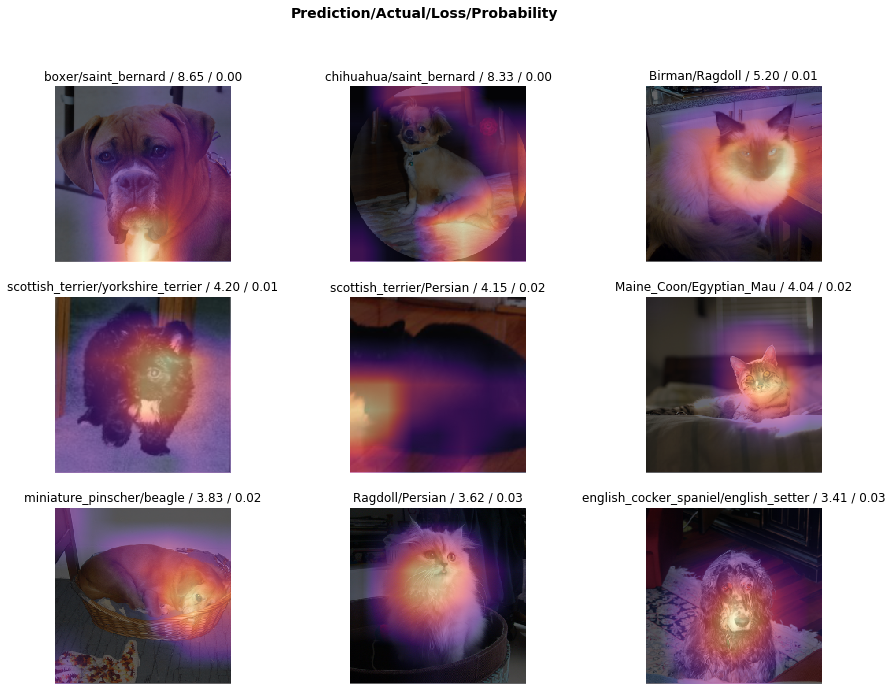

In [60]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

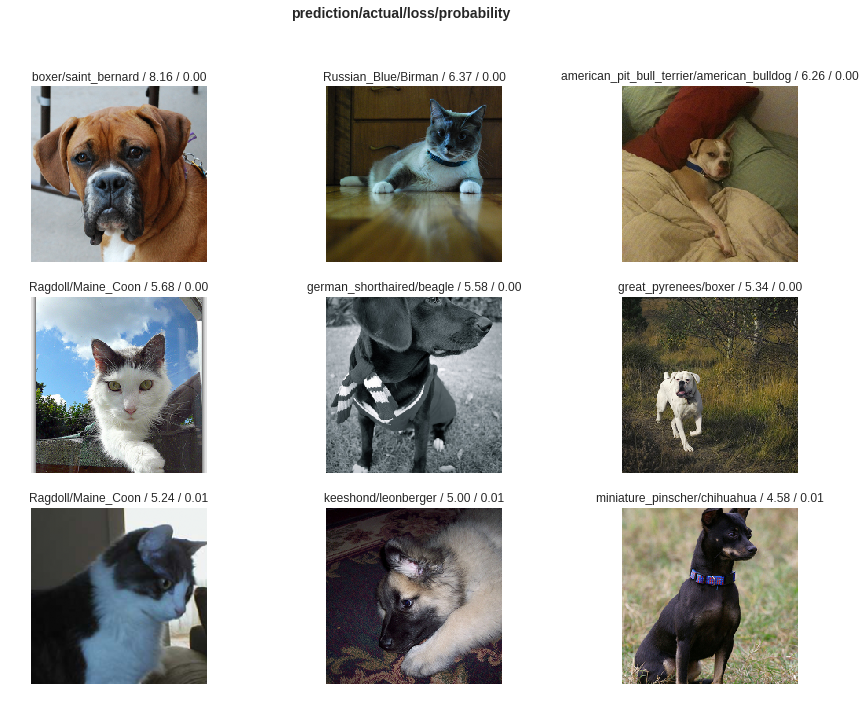

In [28]:
# previous run on Google colab
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [61]:
help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap: bool = False, heatmap_thresh: int = 16, alpha: float = 0.6, cmap: str = 'magma', show_text: bool = True, return_fig: bool = None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.



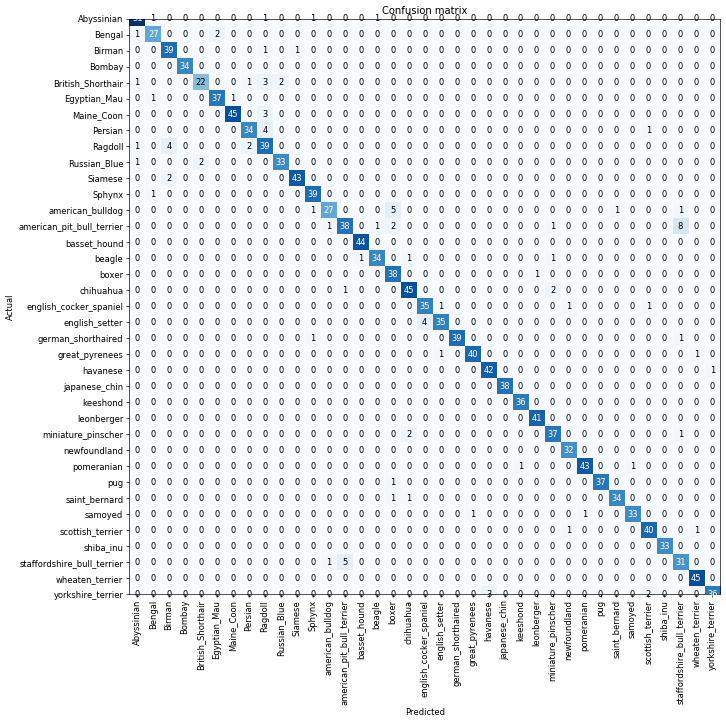

In [62]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [63]:
interp.most_confused(min_val=2)  # display descending order all values other than diagonal. Ignore 1s though.

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('american_bulldog', 'boxer', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Persian', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('english_setter', 'english_cocker_spaniel', 4),
 ('British_Shorthair', 'Ragdoll', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Bengal', 'Egyptian_Mau', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Ragdoll', 'Persian', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('yorkshire_terrier', 'scottish_terrier', 2)]

In [64]:
help(interp.most_confused)

Help on method most_confused in module fastai.train:

most_confused(min_val: int = 1, slice_size: int = 1) -> Collection[Tuple[str, str, int]] method of fastai.train.ClassificationInterpretation instance
    Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences.



## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [65]:
learn.unfreeze()

In [66]:
%%time
learn.fit_one_cycle(1)

CPU times: user 1h 9min 59s, sys: 9min 41s, total: 1h 19min 41s
Wall time: 13min 13s


In [69]:
for i in learn.model.children():
  print(i)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [75]:
learn.load('pets-lesson01-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Egyptian_Mau,pug,basset_hound,Siamese,Birman
Path: /Users/atma6951/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
samoyed,pomeranian,Persian,Siamese,Egyptian_Mau
Path: /Users/atma6951/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [76]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 44min 13s, sys: 6min 4s, total: 50min 18s
Wall time: 8min 19s


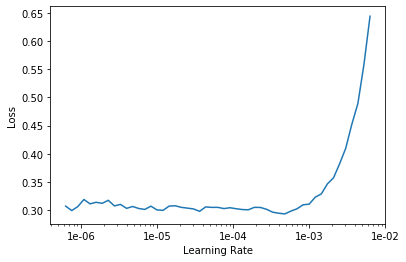

In [77]:
learn.recorder.plot()

In [78]:
%%time
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

CPU times: user 2h 23min 29s, sys: 20min 12s, total: 2h 43min 41s
Wall time: 27min 15s


In [79]:
learn.save('pets-lesson01-stage-2')

In [83]:
data_predict = ImageDataBunch.from_folder()
# from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
#                                   ).normalize(imagenet_stats)

/Users/atma6951/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/Users/atma6951/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


IndexError: index 0 is out of bounds for axis 0 with size 0

In [84]:
data1 = open_image('/Users/atma6951/Documents/temp/predict/British_Shorthair_155.jpg')

In [85]:
learn.predict(data1)

(Category British_Shorthair,
 tensor(4),
 tensor([1.4690e-06, 8.6672e-08, 2.1481e-07, 1.4908e-05, 9.9972e-01, 3.9961e-06,
         5.1319e-06, 1.3717e-04, 1.1824e-05, 1.0145e-04, 5.7425e-07, 8.6432e-08,
         4.8310e-08, 3.5730e-08, 9.4513e-08, 9.4602e-08, 1.7248e-08, 2.2361e-09,
         1.0287e-08, 1.2037e-08, 8.5989e-08, 1.4355e-07, 7.4836e-08, 2.6102e-08,
         2.2787e-08, 4.4394e-08, 5.4594e-09, 1.6253e-06, 2.7272e-08, 3.6290e-07,
         6.4971e-08, 7.2114e-07, 3.4080e-08, 3.1986e-08, 4.0250e-08, 6.2341e-07,
         4.0484e-08]))

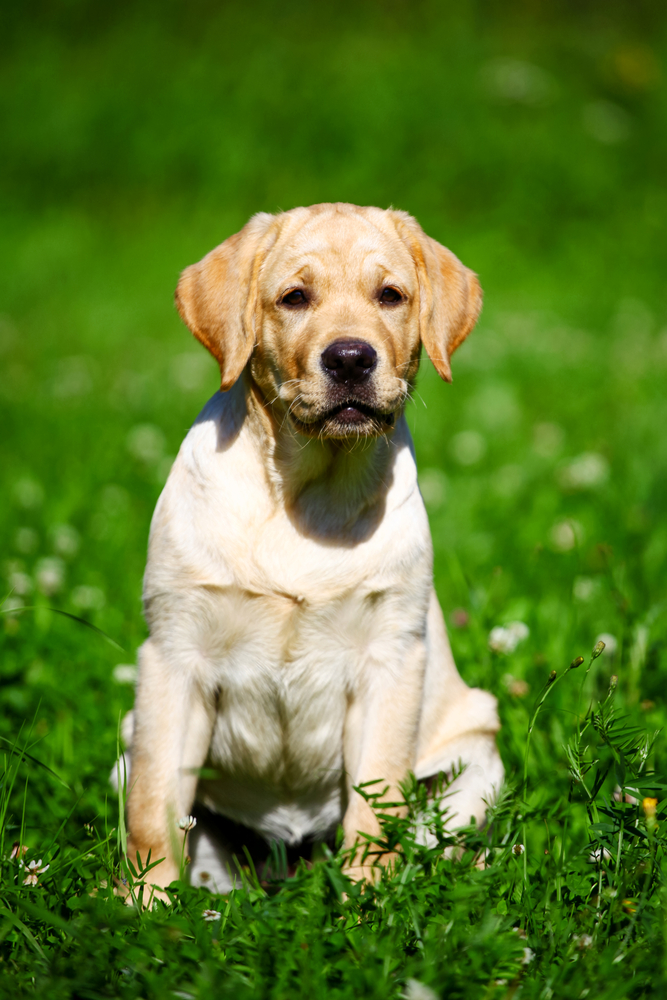

In [87]:
data1 = open_image('/Users/atma6951/Documents/temp/predict/lab1.jpeg')
data1

In [88]:
learn.predict(data1)

(Category beagle,
 tensor(15),
 tensor([8.4056e-04, 8.7666e-04, 3.0126e-04, 6.0895e-04, 1.2559e-04, 5.6399e-04,
         1.2570e-04, 1.4741e-04, 1.5128e-04, 1.3911e-04, 3.2256e-03, 8.1725e-05,
         4.6822e-03, 3.8672e-03, 2.7823e-03, 6.6242e-01, 2.6376e-04, 1.7442e-03,
         4.7391e-02, 2.5870e-02, 2.2379e-01, 2.8906e-03, 1.3585e-03, 7.6220e-04,
         4.9268e-04, 3.6518e-03, 1.3180e-03, 8.0954e-04, 1.3319e-04, 4.1612e-03,
         6.8621e-04, 2.3613e-04, 1.8081e-04, 2.6836e-04, 2.1255e-03, 6.8653e-04,
         2.3307e-04]))

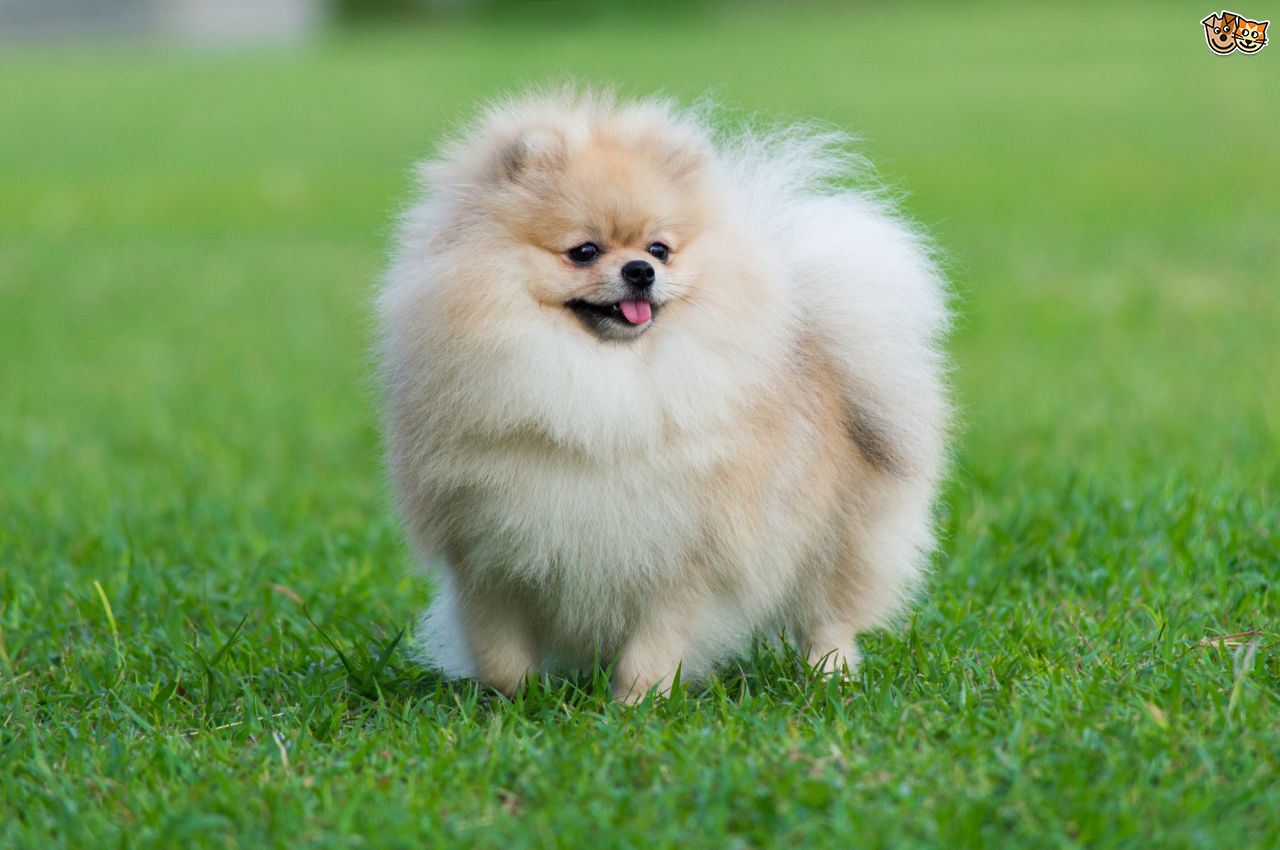

In [89]:
data3 = open_image('/Users/atma6951/Documents/temp/predict/pom1.jpeg')
data3

In [90]:
learn.predict(data3)

(Category pomeranian,
 tensor(28),
 tensor([2.3020e-05, 2.9860e-06, 2.9077e-03, 4.3383e-05, 2.4209e-04, 1.5993e-06,
         6.3204e-05, 2.5213e-02, 1.0091e-03, 1.5174e-06, 4.0261e-05, 1.1935e-06,
         2.4641e-06, 1.2586e-06, 1.3497e-05, 3.8008e-06, 5.6134e-07, 5.6277e-06,
         1.4022e-05, 4.0462e-06, 1.9831e-06, 3.2513e-05, 7.4281e-05, 9.2702e-05,
         2.1358e-03, 3.7560e-04, 4.8540e-06, 7.0426e-05, 9.6549e-01, 8.4393e-05,
         6.2318e-06, 1.8652e-03, 9.2918e-06, 7.1411e-05, 5.2687e-06, 8.1189e-05,
         7.2155e-06]))

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [53]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:03, 27500065.01it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 32 s, sys: 28.1 s, total: 1min
Wall time: 1min 41s


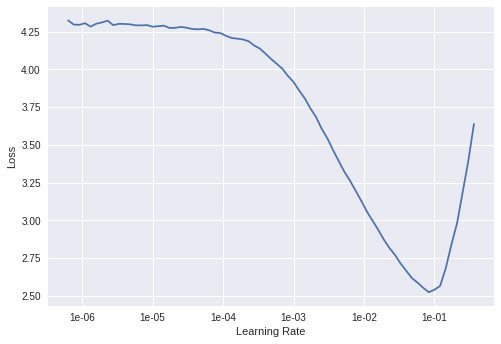

In [54]:
%%time
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

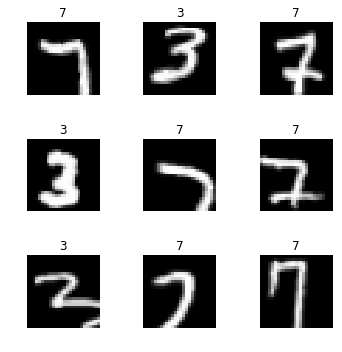

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

name  label
0   train/3/7463.png      0
1  train/3/21102.png      0
2  train/3/31559.png      0
3  train/3/46882.png      0
4  train/3/26209.png      0

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

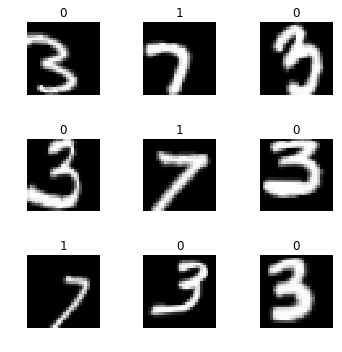

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']